### Biblioteki wykorzystywane w trakcie prowadzenia eksperymentów oraz fukncje i modele ze skryptów

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

### Plan działania

1. Zrobić wgląd w dane i zobaczyć jak one wyglądają : EDA
2. Stworzyć odpowiednie pliki .csv, w których będą wyglądały w następujący sposób:
    - bez żadnych zmian z ceną, ale dodać klasę (label)
    - to samo co powyżej oraz zastosować One-Hot-Encoding na danych kategorycznych
3. Taki podział pozwoli na przetestowanie zarówo modelu do predykcji klasy mieszkania jak i modelu do predykcji ceny mieszkania a następnie na podstawie ceny nastąpi predykcja klasy. Oraz będzie możliwość porównania OHE z Embeddingami

# 1. Wgląd w dostępne dane

In [4]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

display(train_data.head(5))
display(test_data.head(5))

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1,2014,907,16,terraced,individual_heating,management_in_trust,90.0,1174.0,0~5min,0-5min,7.0,20.0,Myung-duk,9,14.0,17.0
2,2007,1629,7,terraced,individual_heating,management_in_trust,7.0,605.0,0~5min,0-5min,5.0,5.0,Banwoldang,5,9.0,5.0
3,2005,743,21,mixed,individual_heating,management_in_trust,67.0,798.0,0~5min,5min~10min,6.0,0.0,Bangoge,7,13.0,15.0
4,2006,903,7,terraced,individual_heating,management_in_trust,123.0,181.0,5min~10min,0-5min,3.0,11.0,Myung-duk,4,8.0,11.0


Zbiór testowy nie ma pokazanej ceny / klasy, ponieważ będzie to zbiór na któym mamy zrobić predykcje wyników.
Przeglądając dane zajmiemy się głównie zbiorem treningowym

### Wgląd w dane kategoryczne

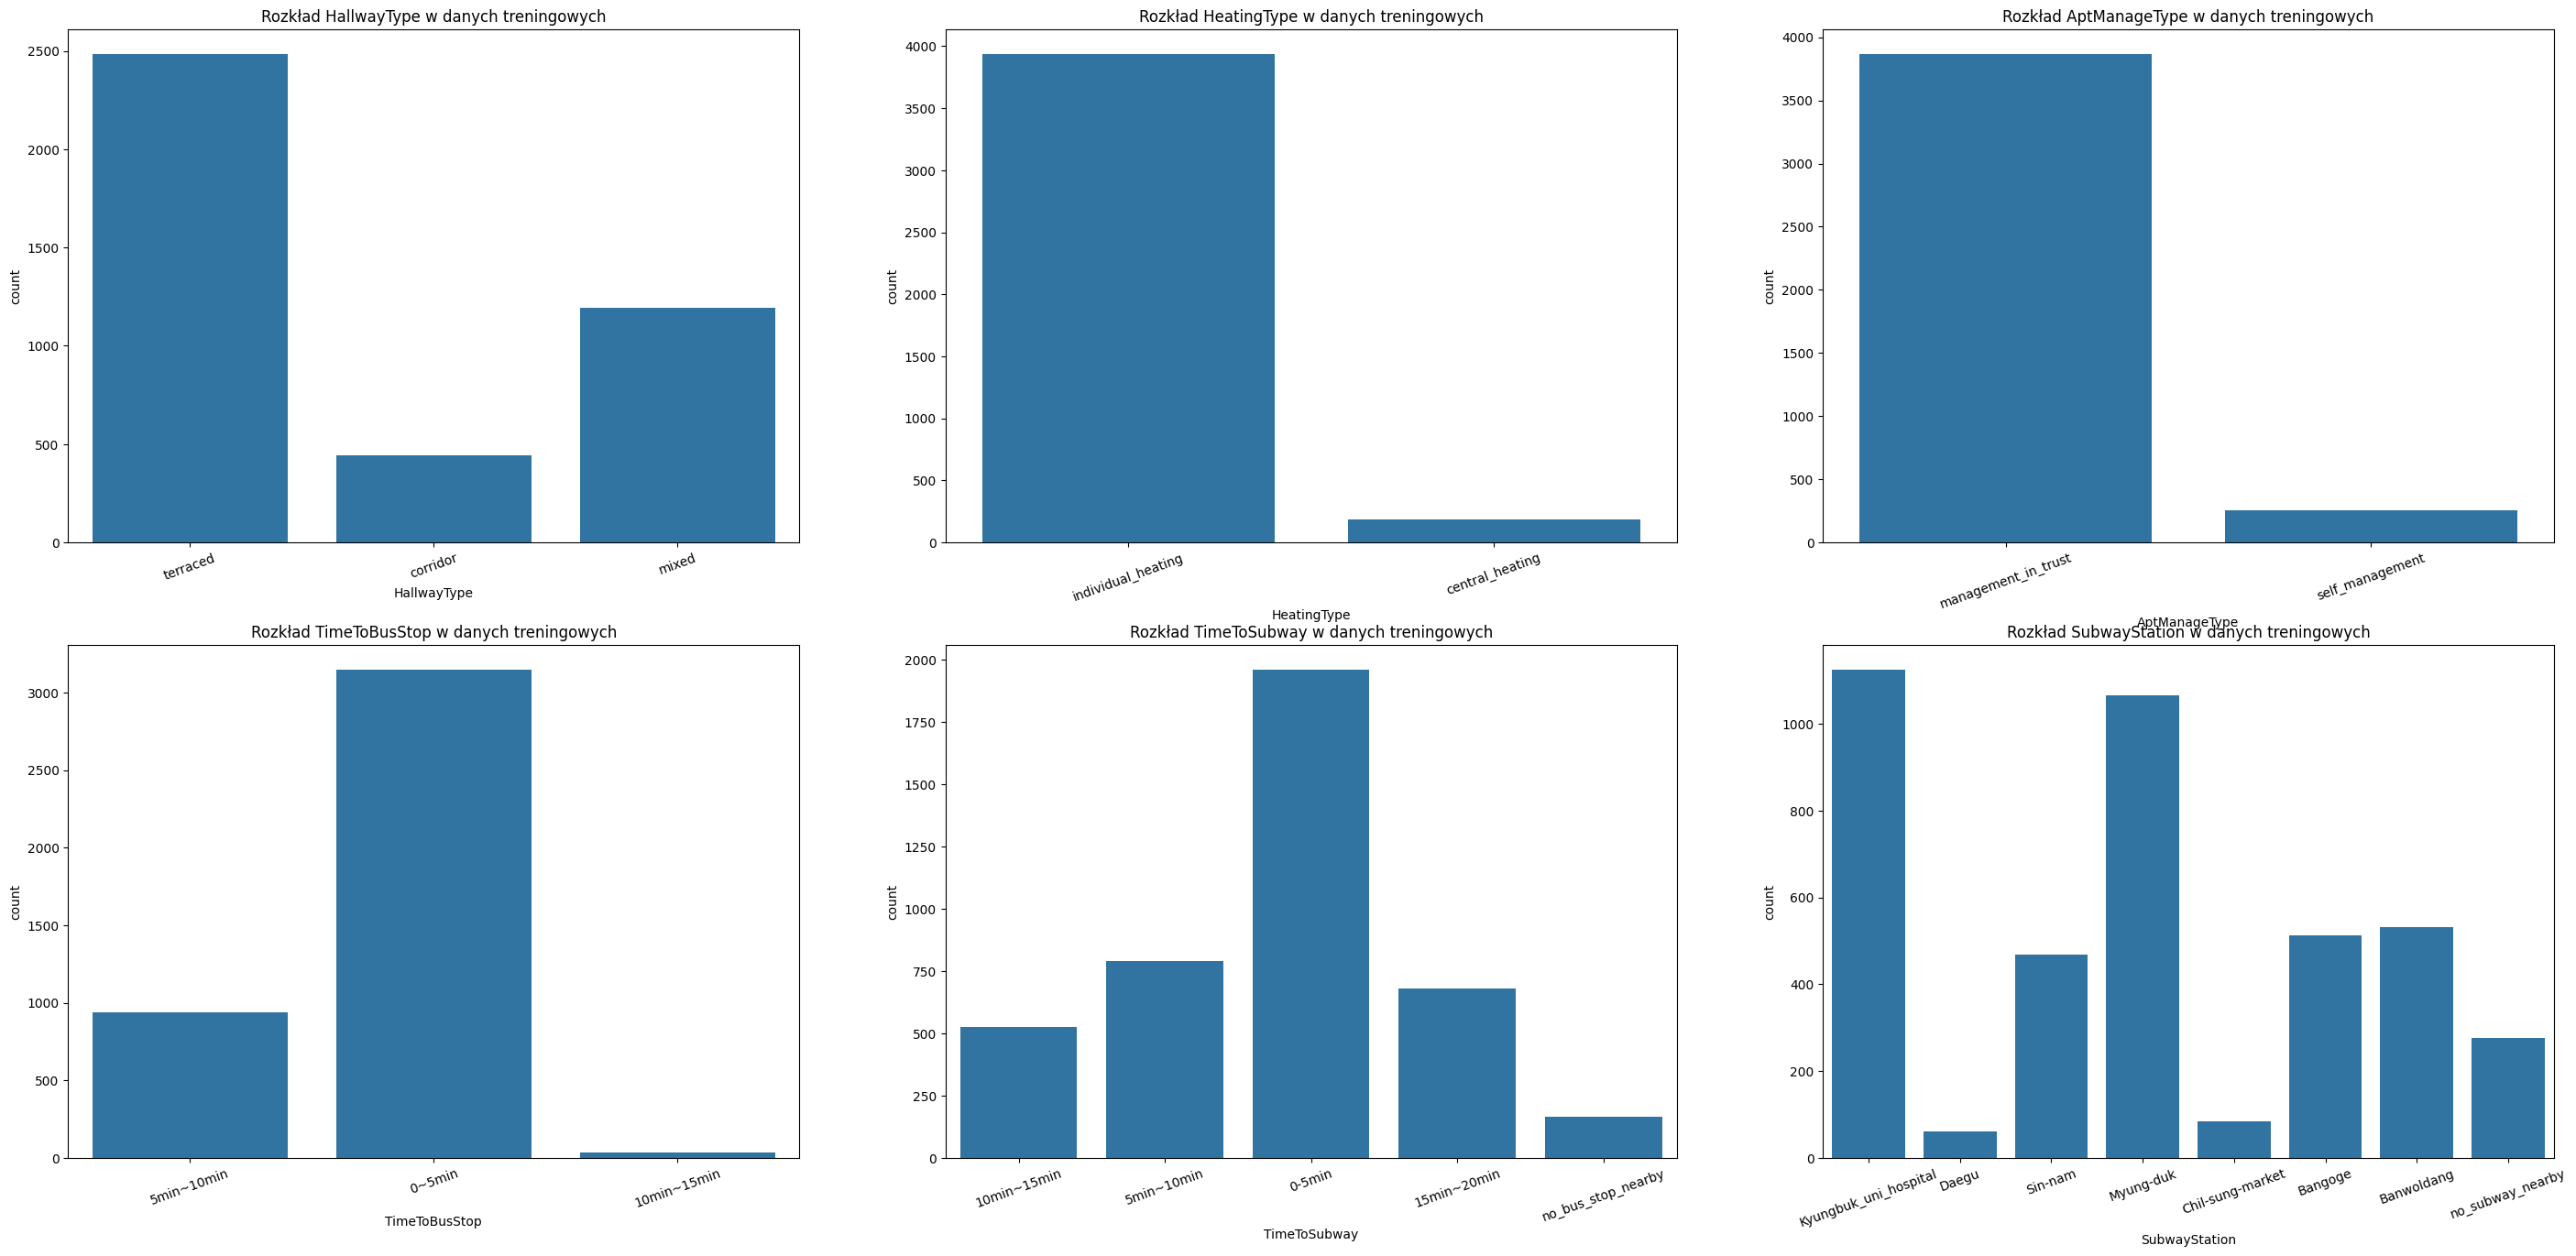

In [5]:
categorical_data = ["HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway", 'SubwayStation']

plt.figure(figsize=(35, 16))
for i, col in enumerate(categorical_data):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=col, data=train_data)
    plt.title(f'Rozkład {col} w danych treningowych')
    plt.xticks(rotation=20)

- Widać, że dane kategoryczne wahają się od 2 do 5 kategorii w danej
- Dobrym pomysłem, może być zastosowanie OHE

### Sprawdzenie czy istnieją brakujące dane

In [6]:
train_data.isnull().sum()

SalePrice                    0
YearBuilt                    0
Size(sqf)                    0
Floor                        0
HallwayType                  0
HeatingType                  0
AptManageType                0
N_Parkinglot(Ground)         0
N_Parkinglot(Basement)       0
TimeToBusStop                0
TimeToSubway                 0
N_manager                    0
N_elevators                  0
SubwayStation                0
N_FacilitiesInApt            0
N_FacilitiesNearBy(Total)    0
N_SchoolNearBy(Total)        0
dtype: int64

- Jak widać, żadna kategoria nie ma brakujących danych, więc nie musimy martwić się co zrobić z brakującymi danymi

### Sprawdzenie outlinerów dla danych numerycznych

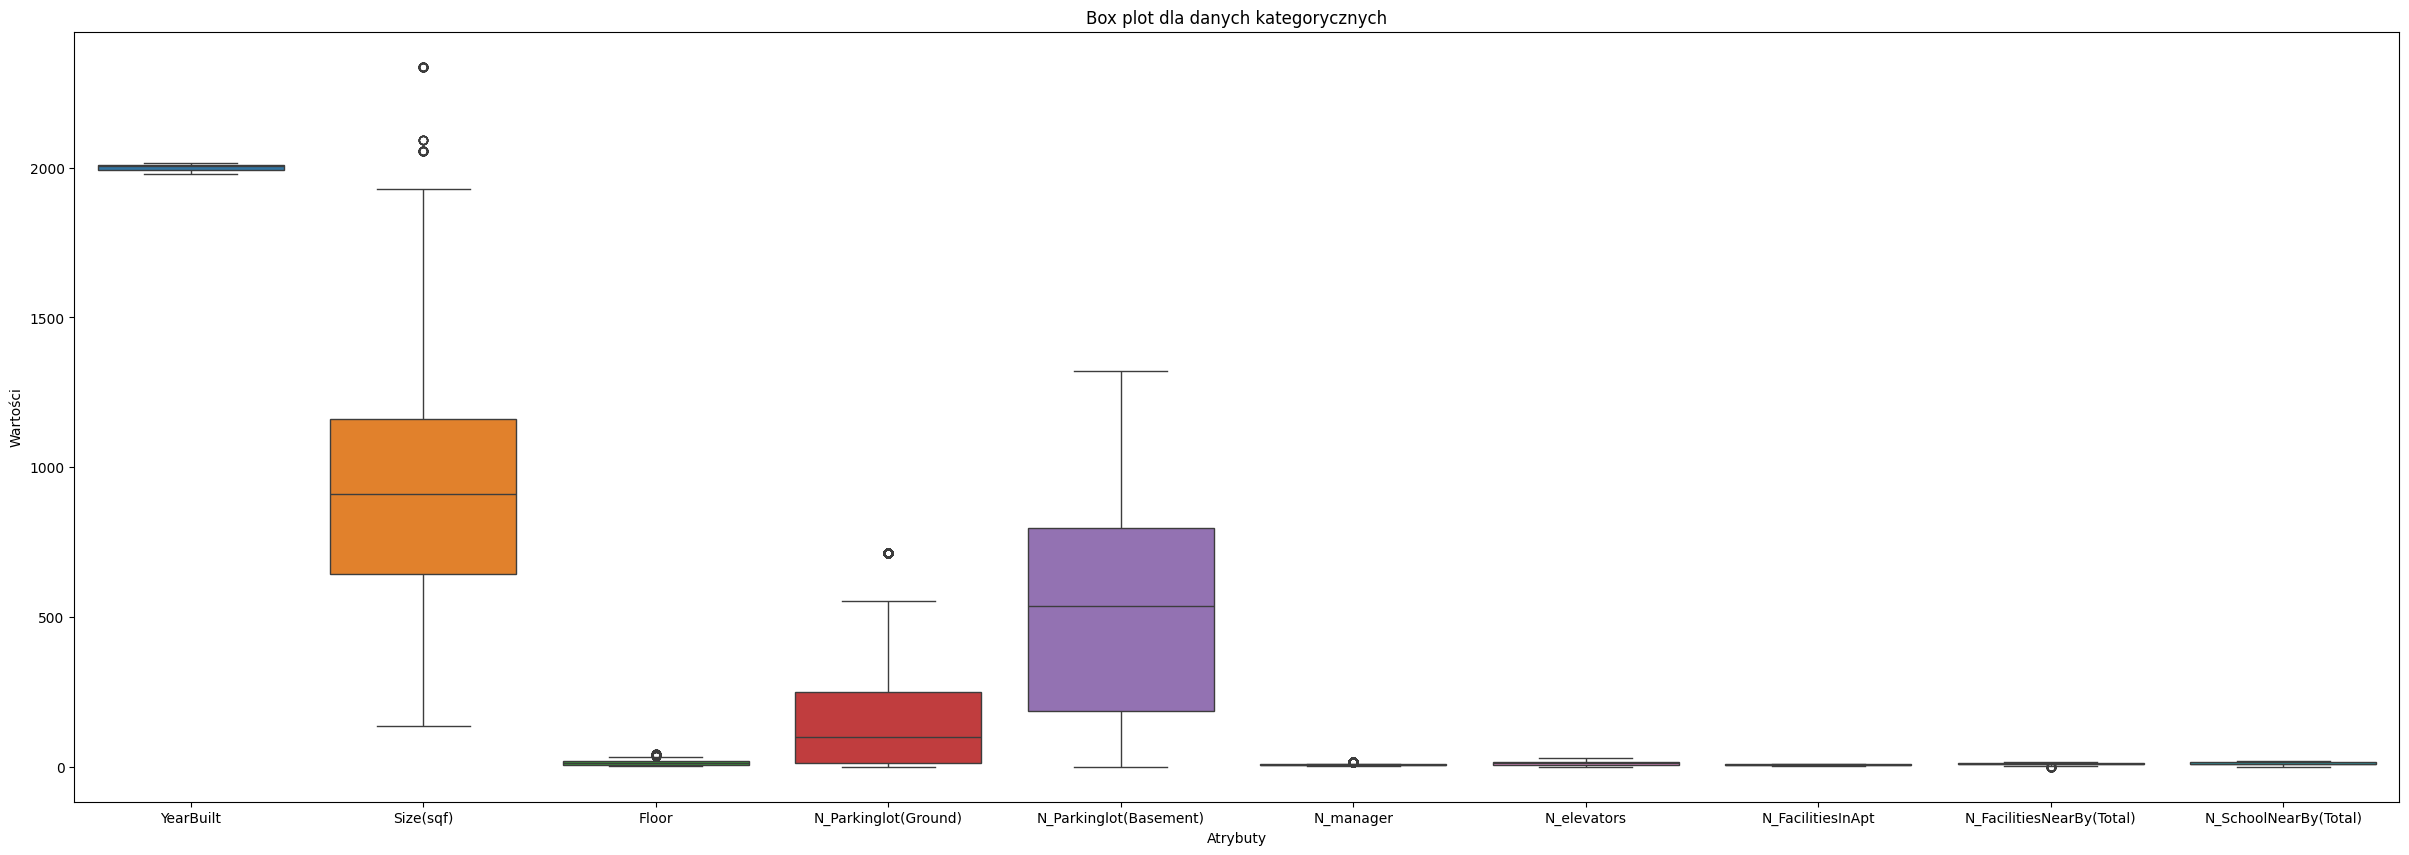

In [7]:
numerical_data = ['YearBuilt', 'Size(sqf)', 'Floor','N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'N_manager',
       'N_elevators', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
plt.figure(figsize=(30, 10))
plt.title("Box plot dla danych kategorycznych")
sns.boxplot(data=train_data[numerical_data], orient='v')
plt.xlabel("Atrybuty")
plt.ylabel("Wartości")
plt.show()


- W niektórych kategoriach pojawiają się dane odstające
- Różne atrybuty mają różne przedziały wartości
- Dobrym pomysłem może być przeskalowanie danych

### Dane numeryczne po przeskalowaniu

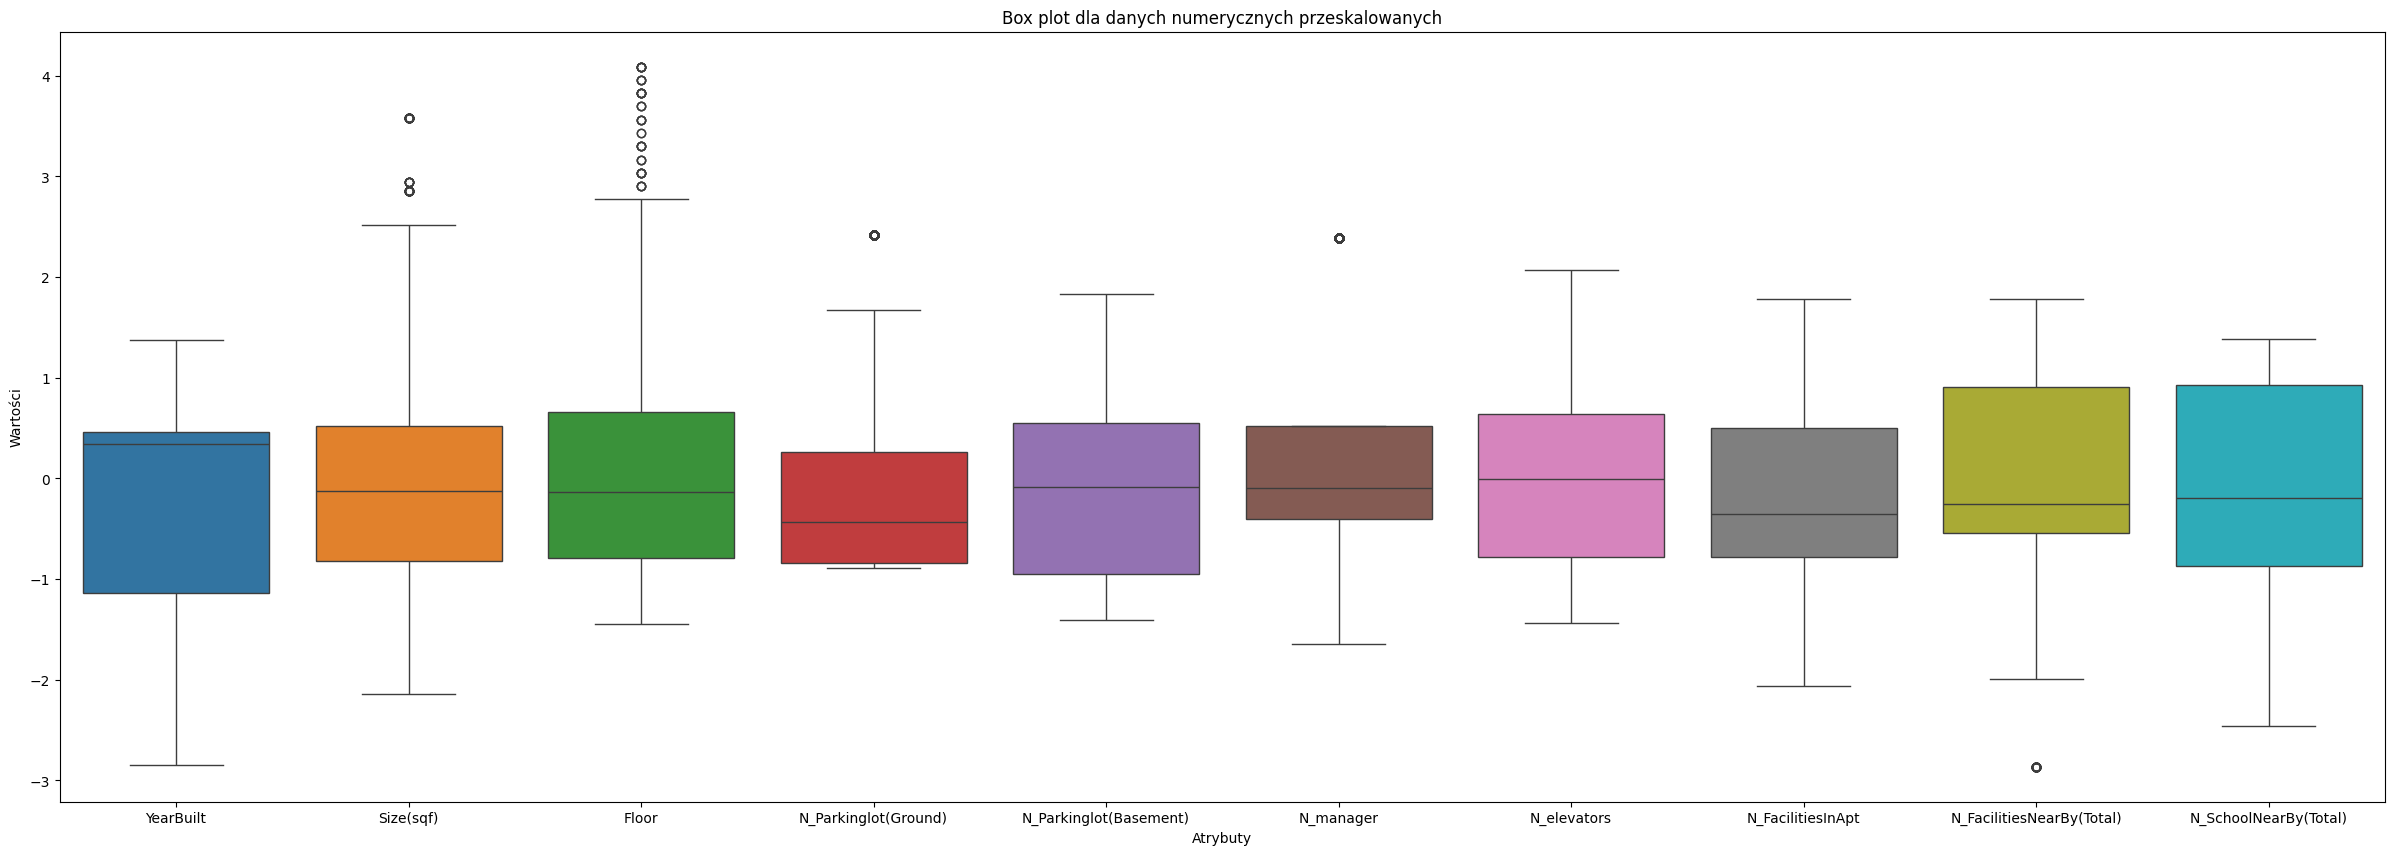

In [8]:
scaled_data = train_data.copy()
scaler = StandardScaler()
scaled_data[numerical_data] = scaler.fit_transform(scaled_data[numerical_data])

plt.figure(figsize=(30, 10))
plt.title("Box plot dla danych numerycznych przeskalowanych")
sns.boxplot(data=scaled_data[numerical_data], orient='v')
plt.xlabel("Atrybuty")
plt.ylabel("Wartości")
plt.show()

- Dalej pojawiają się wartości odstające
- Większość danych jest już w podobnych przedziałach wartości

### Sprawdzenie korelacji danych

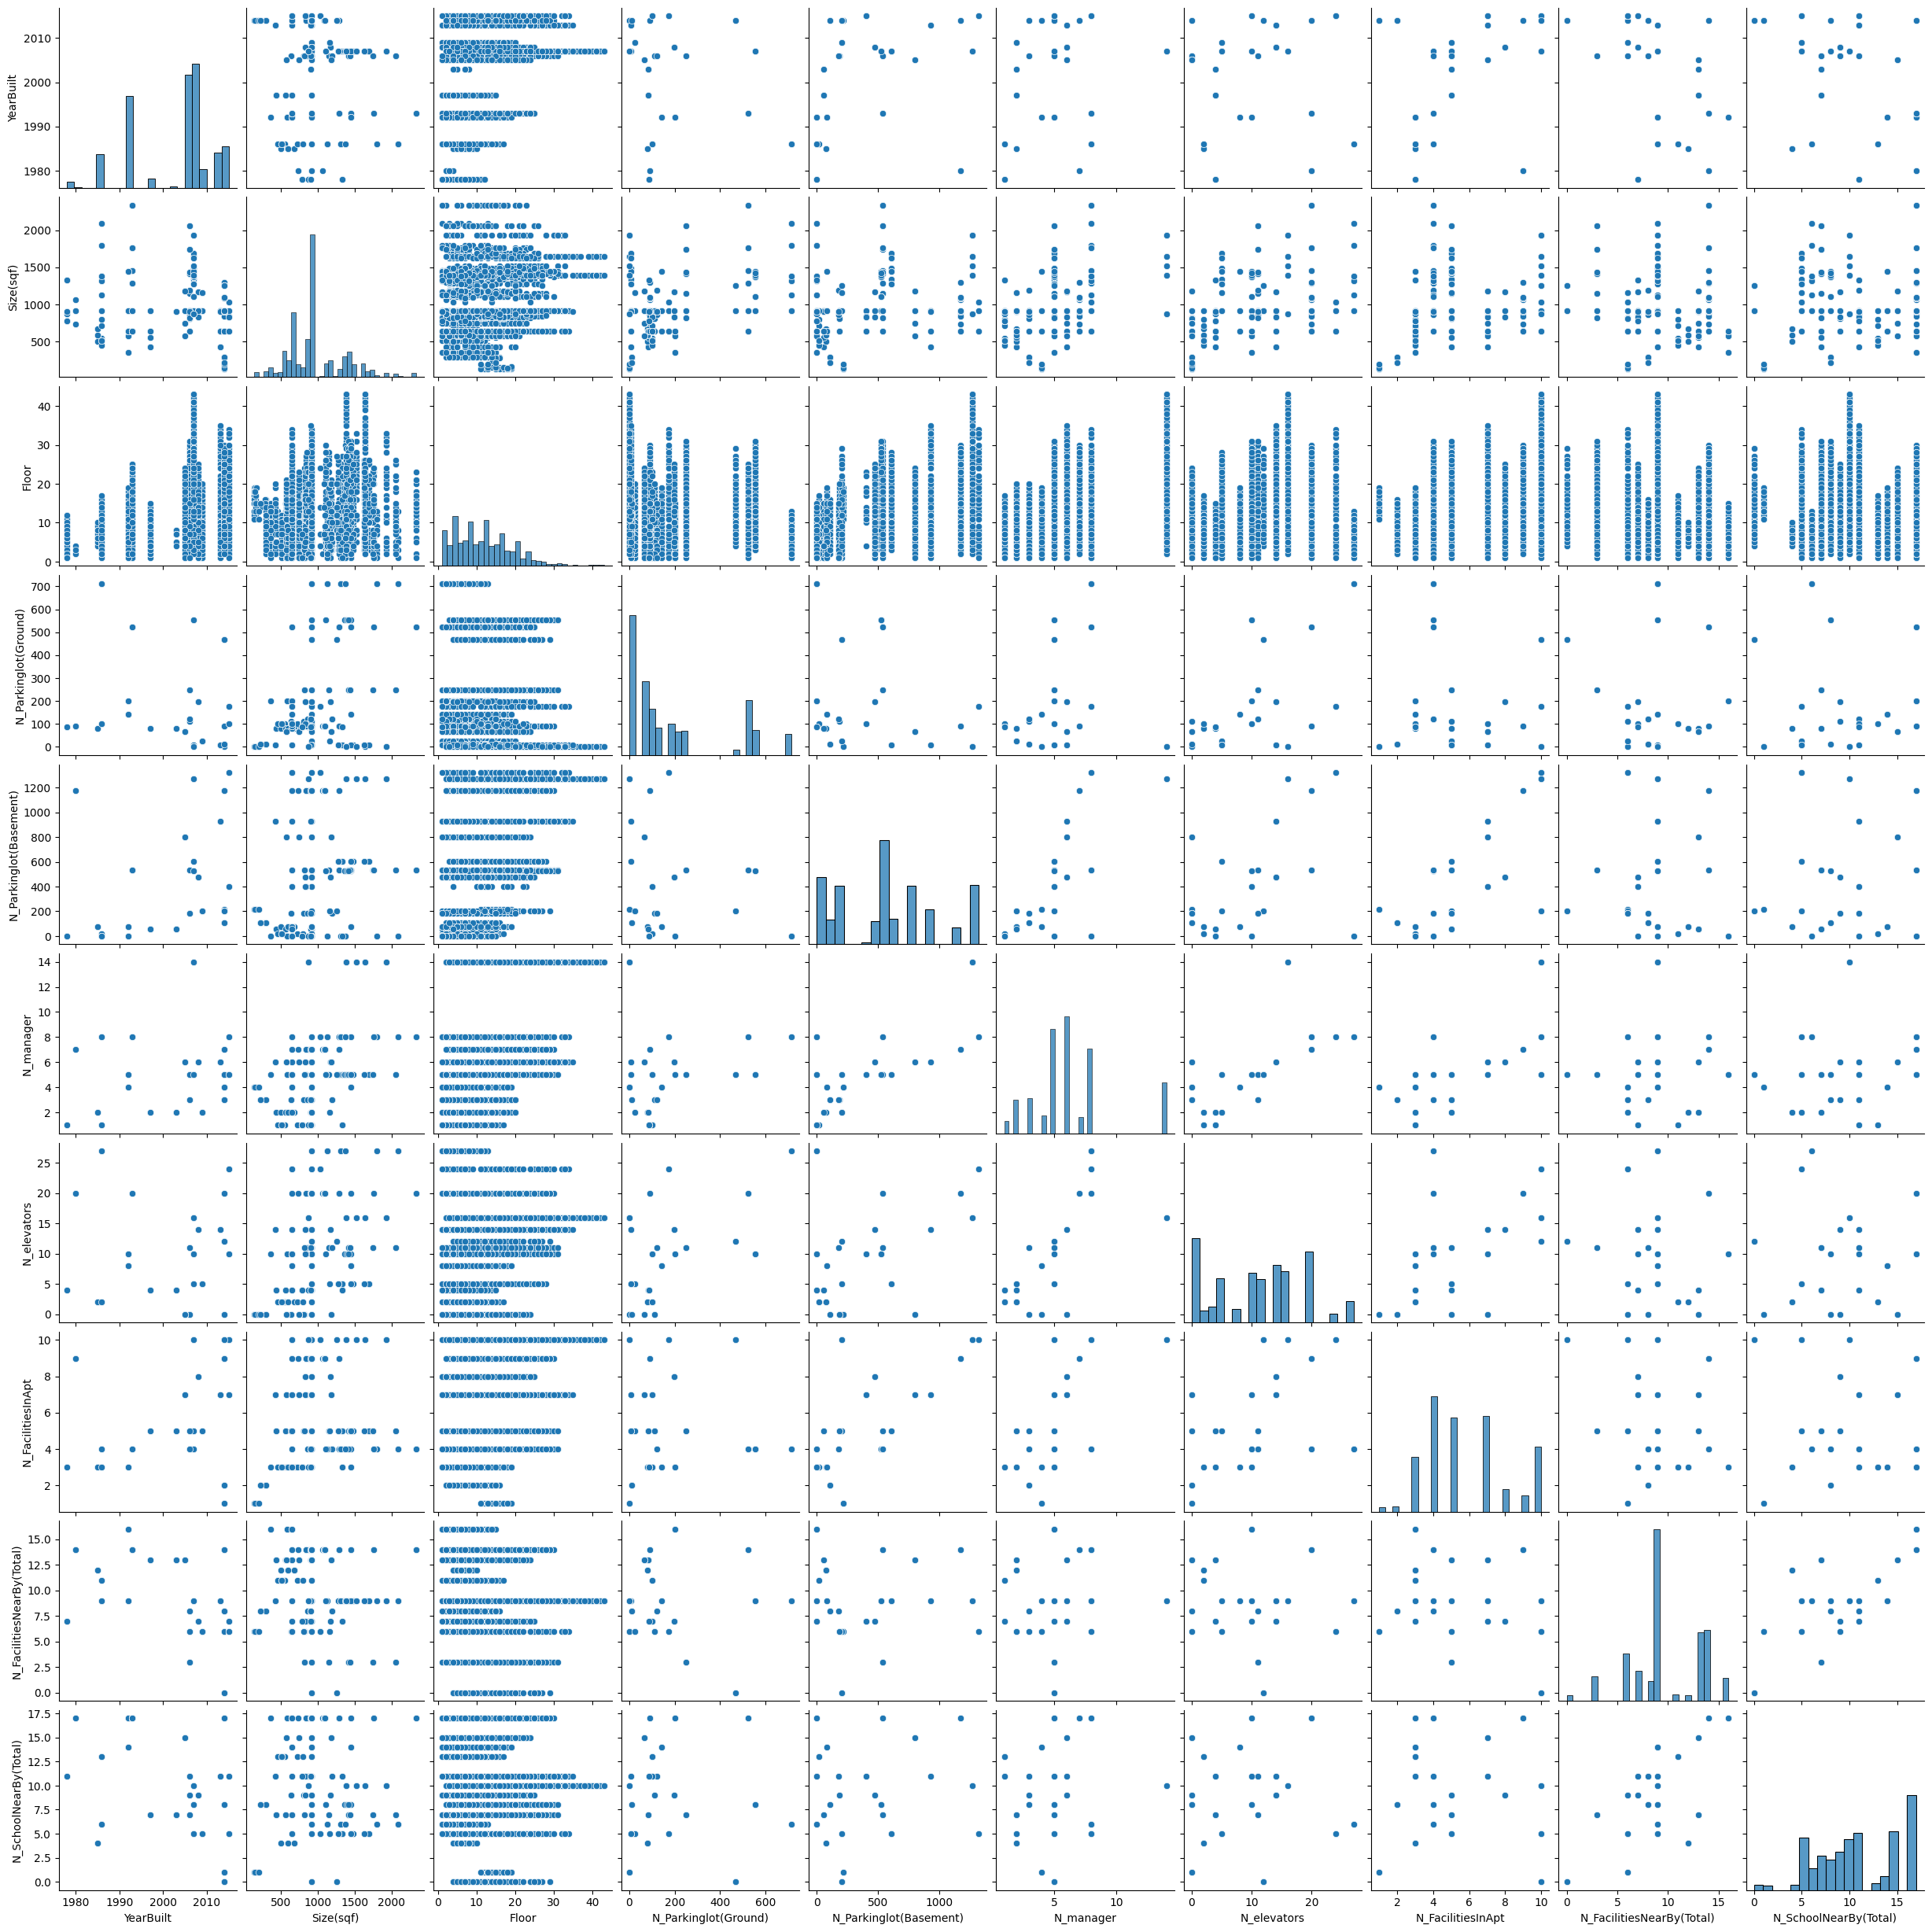

In [9]:
sns.pairplot(train_data[numerical_data])

- Widać, że niektóre dane posiadają jakieś zależności liniowe między sobą : N_FacilitiesNearBy oraz N_SchoolNearBy

### Wgląd w rozkład klas mieszkań

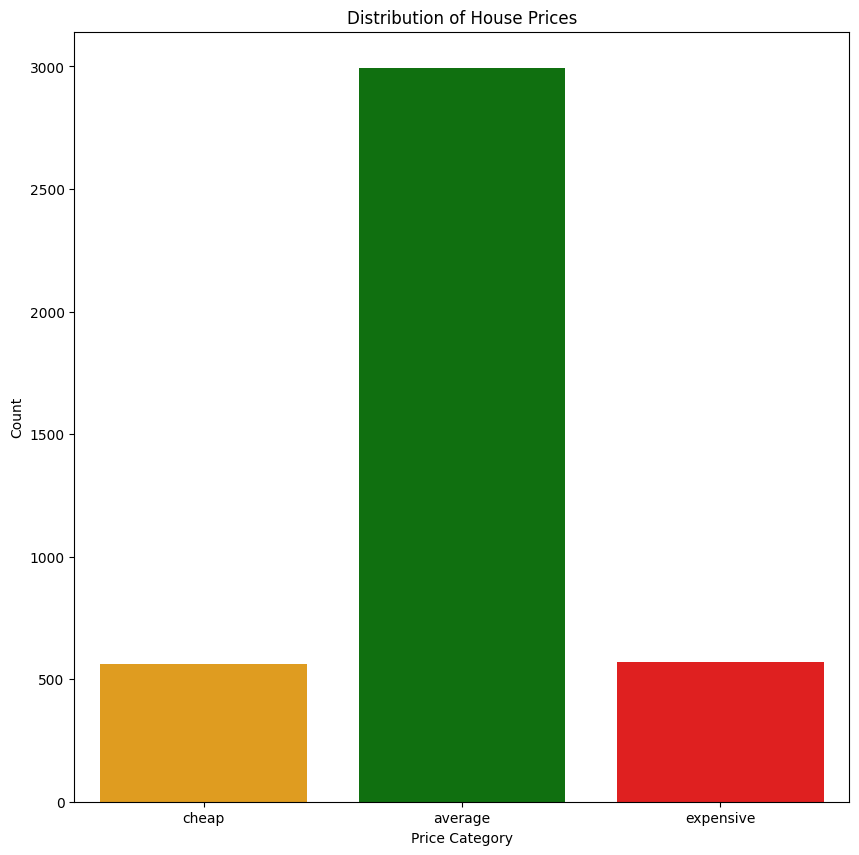

In [13]:
price_series = train_data["SalePrice"].copy()

# Categorize the prices
price_series = price_series.apply(lambda x: 'cheap' if x <= 100_000 else 'average' if x <= 350_000 else 'expensive')

# Define the palette
palette = ['green', 'orange', 'red']

# Plot the categorized prices
plt.figure(figsize=(10, 10))
sns.countplot(x=price_series, palette=palette, hue=price_series,order=['cheap', 'average', 'expensive'])
plt.title('Distribution of House Prices')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()


# 2. Przygotowywanie odpowiednich dataframów

In [14]:
# check if there is a folder data
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

### 2.1 Dodanie klasy mieszkania (tylko na zbiorze treningowym)

In [17]:
train_data_with_labels = train_data.copy()
train_data_with_labels["label"] = train_data_with_labels["SalePrice"].apply(lambda x: 'cheap' if x <= 100_000 else 'average' if x <= 350_000 else 'expensive')
train_data_with_labels.head(5)

train_data_with_labels.to_csv('processed_data/train_data_with_labels.csv', index=False)

### 2.2 Zrobienie One-Hot-Encoding

In [18]:
categorical_data = ["HallwayType", "HeatingType", "AptManageType", "TimeToBusStop", "TimeToSubway", 'SubwayStation']
train_data_with_labels_ohe = pd.get_dummies(train_data_with_labels, columns=categorical_data)
test_data_with_labels_ohe = pd.get_dummies(test_data, columns=categorical_data)

display(train_data_with_labels_ohe.head(5))
display(test_data_with_labels_ohe.head(5))

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,...,False,False,False,False,False,False,True,False,False,False
1,51327,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,...,True,False,False,False,False,True,False,False,False,False
2,48672,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,...,True,False,False,False,False,True,False,False,False,False
3,380530,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,...,False,False,False,False,False,False,False,False,True,False
4,78318,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,...,False,False,False,False,False,False,False,True,False,False


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1993,914,10,523.0,536.0,8.0,20.0,4,14.0,17.0,...,False,False,False,False,False,False,False,True,False,False
1,2014,907,16,90.0,1174.0,7.0,20.0,9,14.0,17.0,...,False,False,False,False,False,False,False,True,False,False
2,2007,1629,7,7.0,605.0,5.0,5.0,5,9.0,5.0,...,False,False,False,True,False,False,False,False,False,False
3,2005,743,21,67.0,798.0,6.0,0.0,7,13.0,15.0,...,True,False,True,False,False,False,False,False,False,False
4,2006,903,7,123.0,181.0,3.0,11.0,4,8.0,11.0,...,False,False,False,False,False,False,False,True,False,False


In [20]:
# change the data type of the one-hot encoded columns to int
one_hot_encoded_columns = ['HallwayType_corridor', 'HallwayType_mixed', 'HallwayType_terraced',
                           'HeatingType_central_heating', 'HeatingType_individual_heating',
                           'AptManageType_management_in_trust', 'AptManageType_self_management',
                           'TimeToBusStop_0~5min', 'TimeToBusStop_10min~15min', 'TimeToBusStop_5min~10min',
                           'TimeToSubway_0-5min', 'TimeToSubway_10min~15min', 'TimeToSubway_15min~20min',
                           'TimeToSubway_5min~10min', 'TimeToSubway_no_bus_stop_nearby',
                           'SubwayStation_Bangoge', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market',
                           'SubwayStation_Daegu', 'SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk',
                           'SubwayStation_Sin-nam', 'SubwayStation_no_subway_nearby']

train_data_with_labels_ohe[one_hot_encoded_columns] = train_data_with_labels_ohe[one_hot_encoded_columns].astype(float)
test_data_with_labels_ohe[one_hot_encoded_columns] = test_data_with_labels_ohe[one_hot_encoded_columns].astype(float)

display(train_data_with_labels_ohe.head(5))
display(test_data_with_labels_ohe.head(5))

train_data_with_labels_ohe.to_csv('processed_data/train_data_with_labels_ohe.csv', index=False)
test_data_with_labels_ohe.to_csv('processed_data/test_data_with_labels_ohe.csv', index=False)

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,51327,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,48672,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,380530,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,78318,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1993,914,10,523.0,536.0,8.0,20.0,4,14.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2014,907,16,90.0,1174.0,7.0,20.0,9,14.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2007,1629,7,7.0,605.0,5.0,5.0,5,9.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005,743,21,67.0,798.0,6.0,0.0,7,13.0,15.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006,903,7,123.0,181.0,3.0,11.0,4,8.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
